In [ ]:
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Book recommender

Problem: Book recommendations - „I like Lord of the Rings, what else should I read?“
<br><br>
Goal:
- take some data, try some approaches, produce some code, get some results
- then come and show us your solution and have a chat around it - show how you think
about a specific problem, how you are able to explain what approach you used and why, think about the limitations of the approach and how things could be improved if there was more time, what you think of the results and if they make sense, etc.
<br>

Philosophy:
- the actual result and code are not that important – the journey there and potential
future paths are more important
- if you are able to follow-through with some ideas then great, if you just start
something and have a clear idea on how to proceed that is also useful
- the expectation is that you will spend an evening or two with the task (but there are
no bounds to proactivity if you enjoy playing with the problem)
<br>

Data:
- available open dataset: http://www2.informatik.uni-freiburg.de/~cziegler/BX/
- alternatively feel free to grab any other relevant data set
<br>

Tools:
- use whatever you are comfortable in (R, Python, Matlab, Java, SQL,...) or feel free to
use it as an opportunity to try out a new language
- it is not a contest in finding the best black-box library and blindly using it – own
solutions are preferred even if they are simple
- how to present: up to you – slides, walking through code, drawing, ...

Additional data:
* [Goodreads dataset](https://github.com/zygmuntz/goodbooks-10k)

In [ ]:
# set styling for visualization
sns.set_style('darkgrid', {'axes.facecolor': "#E5EAEF"})
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 2})
plt.rcParams["figure.figsize"] = (13,8)

# default setting for jupyter notebook
pd.set_option("max_columns", 100)
pd.set_option("max_rows", 1000)
pd.set_option("max_colwidth", None)

In [ ]:
# load data - http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 
def load_data(path):
    return (pd.read_csv(path, sep=";", encoding='CP1252', escapechar='\\'))

path = "/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/"

book_ratings = load_data(path + "BX-Book-Ratings.csv")
books = load_data(path + "BX_Books.csv") # warning, has one row with ";" inside text field
users = load_data(path + "BX-Users.csv")

In [ ]:
book_ratings.info()

In [ ]:
book_ratings.head(2)

In [ ]:
books.info()

In [ ]:
books.head(2)

In [ ]:
users.info()

In [ ]:
users.head()

> 💡 Idea
>
> **What variables can I potentially miss?**
> - `description` of the book: recommending similar topics, could be solved by categorization to tags / keywords
> - author details (these are mainly hypotheses for further exploration):
>   - `gender`: men might not be interested in women topics and novels, but could be solved by categorization to tags / keywords
>   - `age`: user might be more interested in books from authors with similar age due to same cultural/historical background, problematic with deceased authors 
>   - `location`: user may be interested in authors coming from similar location, i.e. Czech user interested in Czech author, or Polish user in Polish author 
> - `languages`, in which the book is available: we do not want to recommend books that are in the language not known to the user, because he/she would not be able to read it anyway (prefilter the language at the beginning)
> - `keywords`: similarity of the books, content-based approach
> - `genre`: recommending similar books based on genre, they have higher probability that the user will read them
> - `link between the genres`: can help us with expanding the recommendation to other genres, that user might not have read yet but might be interested in (i.e. reader or historical novels can be interested in war literature even though he/she did not read anything like that yet)
> - `protagonist`: we might relate more to the communication style of main characters with the same gender
> - `writing style`: diary form, poetry, ich form, changing point of views, not categorized in genre but different people might be comfortable with different storytelling
> - `user behavior`: this may contain data about how the users interacts with the books, what books he/she saves for later to read, or to buy, wish lists, favourite authors, clicks from the frontend
> - `parent book id`: ISBN may not be appropriate to be used for recommendations, because unlike films and songs, **they can have many editions**

**A lot of these variables can be found in [Goodreads dataset](https://github.com/zygmuntz/goodbooks-10k)**
* `books.csv`: additional detailed data about the books 
* `ratings.csv`: ratings (user + book + rating), sorted by time, rating 1-5 (Book Crossing has ratings 1-10)
* `to_read.csv`: books saved to read by the user (user + book), sorted by time
* `book_tags.csv`: tags assigned to the books (book + tag + count)
* `tags.csv`: dimensional table (tag id + name), manual input by users

**Solves the problem with editions, because it has** `work_id` **which refers to the book in the abstract sense** (i.e. `book_id` in ratings / to_read datasets maps to `work_id`, not `goodreads_book_id`, datasets have aggregated data for different editions). However, there is also a lot of preprocessing that needs to be done with this dataset (i.e. tags). More information also [here](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/).


In [ ]:
# load data - goodreads
def load_gd_data(path):
    return (pd.read_csv(path, sep=",", error_bad_lines=False))

path = "/kaggle/input/goodbooks-10k/"

books_gd = load_gd_data(path + "books.csv")
ratings_gd = load_gd_data(path + "ratings.csv")
to_read_gd = load_gd_data(path + "to_read.csv")
book_tags_gd = load_gd_data(path + "book_tags.csv")
tags_gd = load_gd_data(path + "tags.csv")

In [ ]:
# there is the same number of books and editions
print(books_gd.book_id.nunique())
print(books_gd.work_id.nunique())

In [ ]:
books_gd.head(2)

In [ ]:
tags_gd.tail(2)

# Data Cleaning and Exploration

## Book Ratings

In `Book-Rating` dataset, there are no duplicite ratings based on ISBN and user combination.

The ratings are either implicit (= 0), or explicit (1-10). The explicit ratings are negatively skewed (more values are plotted on the right side).

In [ ]:
print(
    "The length of the dataset is", 
    book_ratings.shape[0],
    ", after we drop the duplicates, the length is",
    len(book_ratings[['User-ID', 'ISBN']].drop_duplicates()), "."
)

if book_ratings.shape[0] == len(book_ratings[['User-ID', 'ISBN']].drop_duplicates()):
  print("This means there are no duplicate ratings in the data.")
else:
  print("This means there are duplicate ratings in the data.")

In [ ]:
sns.countplot(x="Book-Rating", data=book_ratings);

In [ ]:
sns.countplot(x="Book-Rating", data=book_ratings.query("`Book-Rating` > 0"));

In [ ]:
print(
    "Average rating is",
    round(book_ratings.query("`Book-Rating` > 0")['Book-Rating'].mean(),2)
)

## Books

As already indicated, there are books with multiple editions in the dataset - there are ~270k ISBNs and ~242k book titles. 

Books with publication year > 2021 were excluded from the data.

In [ ]:
books.shape

In [ ]:
books.nunique()

In [ ]:
sns.histplot(x="Year-Of-Publication", data=books, bins=1000)
plt.xlim(1900,2020);

In [ ]:
# exclude books with publication year >= 2021
books = books.query("`Year-Of-Publication` <= 2021")

## Users

In `Users` dataset, there are no duplicate users. Most of the users come from English speaking countries, majority from the U.S.

**However, there are approx. 1,200 users with age over 100 and under 6 (>1%). We should discard them as invalid, but maybe we will be discarding a pattern from the dataset as there will always be users that do not fill in their age at all or will fill it incorrectly - what do they have in common? Or we could bring bias to our recommender if we let them in the dataset. We will treat them as outliers and remove them from data now, but this is something to be explored.**

In [ ]:
users.shape

In [ ]:
users.nunique()

In [ ]:
sns.histplot(users["Age"]);

In [ ]:
# dataset with outliers
age_outliers = users.query("Age > 100 or Age < 6")

# user ids with invalid age
user_outliers = age_outliers["User-ID"].to_list()

age_outliers.shape

In [ ]:
# is there a pattern, do they come from specific location?
age_outliers["Location"].value_counts().to_frame().head()

In [ ]:
# extract country from location and check most common
countries = users['Location'].apply(lambda row: str(row).split(',')[-1])
countries.value_counts().to_frame().head(10)

## Goodreads

In [ ]:
print(
    "There are", books_gd.shape[0], "books,", 
    tags_gd.shape[0], "tags,", 
    ratings_gd.shape[0], "ratings, and", 
    ratings_gd["user_id"].nunique(), "users in goodreads dataset."
)

In comparison to Goodreads, there are 6 times less ratings in Book-Crossing dataset and no tags, however there are significantly more books and users. It has only explicit ratings, on a scale 1-5. Also, the tags would need a lot of cleanup, because they were created by users, so there are a lot of duplicities (`favourites`, `favorites`, `f a v o r i t e s` etc.) which in this state is not useful. 

We might take advantage of the additional data of the `books.csv` dataset and join them on `Book-Crossing` dataset using `ISBN`, but since there is only a fragment of books, it would not be beneficial to build a recommender system using such little data. 

However, since we will need to figure out how to tackle the cold start problem when we do not know anything about the user and want to recommend most popular books, this dataset may come in handy since it is based on 10k most popular books. 

| | Goodreads | Book-Crossing |
| ------| -------- | ------- |
| Ratings | 6 mil | 1.1 mil |
| Tags | 34k | - |
| Users | 53k | 278k |
| Books | 10k | 242k |

In [ ]:
print(
    "The length of the dataset with ratings is", 
    ratings_gd.shape[0],
    ", after we drop the duplicates, the length is",
    len(ratings_gd[['book_id', 'user_id']].drop_duplicates()), "."
)

if ratings_gd.shape[0] == len(ratings_gd[['book_id', 'user_id']].drop_duplicates()):
    print("This means there are no duplicate ratings in the data.")
else:
    print("This means there are duplicate ratings in the data.")

In [ ]:
print(
    "There are", 
    len(books_gd.query("original_publication_year > 2021")),
    "books with publication year over 2021."
)

In [ ]:
sns.countplot(x="rating", data=ratings_gd);

In [ ]:
print(
    "Average rating is",
    round(ratings_gd['rating'].mean(),2)
)

# Preparation of the dataset

## Book-Crossing

`Book-Crossing` datasets will be joined to have book title, author, year of publication, user, his/her rating, country, and age. 

The ratings are connected to the ISBNs, so if were to build the recommender system using this data, we need to think about whether to switch the ISBNs with book titles to avoid recommending the same book only with different edition (also we need to make sure we are not grouping the same book titles from different authors). It could be possible to make recommender prefilter the data to exclude too similar books.

Also, the recommender system will be based on explicit ratings, even though implicit ratings can be helpful as well.

> 💡 Idea
>
> Image information can be useful if we were to analyze the implicit ratings - what on the cover drives the users' attention to check the book? What are other characteristics that the books with implicit ratings have in common?

In [ ]:
# join books and ratings, keep only explicit ratings
df_prep_step_1 = pd.merge(books, book_ratings.query("`Book-Rating` > 0"), on='ISBN', how='inner')

# join users data
df_prep_step_2 = pd.merge(df_prep_step_1, users, on='User-ID', how='inner')

In [ ]:
# dataset with isbn to try to teach the recommender system to exclude very similar books
df_prep = df_prep_step_2.drop(['Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)
df_isbn = df_prep.drop_duplicates()

In [ ]:
print(
    "When joining the data, we lost", 
    book_ratings.shape[0] - df_prep_step_1.shape[0],
    "ratings because some users rated books that were not in the books table, and",
    df_prep_step_1.shape[0] - df_prep_step_2.shape[0],
    "ratings because some users were not present in the users table.",
)

In [ ]:
# exclude age outliers
df_isbn = df_isbn[~df_isbn["User-ID"].isin(user_outliers)]

# add country and drop location
df_isbn['Country'] = df_isbn['Location'].apply(lambda row: str(row).split(',')[-1])
df_isbn = df_isbn.drop('Location', axis=1)

# fill in missings
df_isbn[['Book-Author', 'Country']] = df_isbn[['Book-Author', 'Country']].fillna('Unknown')

# fill in missing age using mean - NOT IDEAL, FOR NOW ONLY FOR EXPLORATORY PURPOSES
users_mean_age = users[~users["User-ID"].isin(user_outliers)]['Age'].mean()
df_isbn['Age'] = df_isbn['Age'].fillna(users_mean_age)

In [ ]:
print(
    "In addition,", df_prep.drop_duplicates().shape[0] - df_isbn.shape[0], "ratings were removed due to exclusion of age outliers."
)

In [ ]:
# missing data
df_isbn.isnull().sum()

## Potential problems with the data and questions that remain unresolved
1. **Best method to impute missing age**: there are several approaches - mean, median. 
2. **Users rating different versions of the book**

What does it say if a user rated the same book 2 and 8? Was it a mistake, or the preferences change in time, or there was something in relation to the edition that the user did not like? Should we take the last rating, or average rating, or exclude it completely from the dataset?

Also, if a user rated the same book 10 and 10, does it mean he liked it more than other books with only one 10-star rating? Do we exclude one rating, or keep them both in the dataset?

In [ ]:
# example of users rating the same book multiple times
df_isbn.groupby(['Book-Title', 'Book-Author', 'User-ID']).size().reset_index(name='Count').sort_values(by='Count', ascending=False).query("Count > 1").head(10)

In [ ]:
# example of a user giving different ratings to the same book 
df_isbn.query("`User-ID` == 11676 and `Book-Rating` > 0 and `Book-Title` == 'Pet Sematary'")

In [ ]:
# example of a user giving the same rating multiple times to the same book
df_isbn.query("`User-ID` == 189835 and `Book-Rating` > 0 and `Book-Author` == 'Stephen King' and (`Book-Title` == 'The Shining' or `Book-Title` == 'The Gunslinger (The Dark Tower, Book 1)')")

## Goodreads

In [ ]:
print(ratings_gd.shape)
print(len(ratings_gd[['user_id', 'book_id']].drop_duplicates()))

In [ ]:
# drop duplicate ratings
ratings_gd = ratings_gd.sort_values('rating').drop_duplicates(subset=['user_id', 'book_id'], keep='last')

# Recommendation system approach

Ideally, we want to recommend books:   
* that the users **have not read yet and will likely to read**
* that are similar to what users already read **but that are also NOT TOO similar**
* that are diverse, so the similarity may not need to be high in all cases - we want to bring the user novel ideas, novel topics, novel genres
* that are generally higher quality, based on ratings or popularity, **but we also want to recommend books that are new releases**
* also, if we do not know anything about the user, we want to have at least some list of books ranked by popularity/ratings based on some attributes

# Lists of TOP books

General way to start would be to prepare a list of books ranked by popularity/ratings, which will be useful in case we have no data from the user. This will be a starting point - for a new user, we recommend the most popular items (i.e. in the user's area). 

> Pros: solves cold start problem
>
> Cons: not personalized

What we need is a dataset including average rating of the book and the number of users that gave the review. The goodreads dataset may serve better in this usecase because it has already preaggregated average ratings from thousands of users, including tags which can be used to create a list of TOP N currently read books, TOP N favourite books, TOP N books based on genre etc. 

However, trending books based on location may also be useful to users, this can be done using Book-Crossing dataset only.

There are two main problems:

* weighting, we need to find overall `N`, because average rating of 9 from 10 users would score better than average rating 8.5 from 10000 users, which won't be correct, typically related to new releases
  * for example IMDB has weighted calculation, which can be replicated
* `ISBN` refers to a specific edition of the book, we need some `parent_id`
  * should be accessible in goodreads datasets as `work_id`, note that there is the same number of `book_id` (specific edition) and `work_id`s, so we do not need to worry about this now, but this needs to be implemented for the future

## Best rated books

### Goodreads

In [ ]:
# average ratings
avg_rating = books_gd.average_rating.mean()

# choose reasonable percentile - find the number of ratings that 90% of books have
p_90 = books_gd.ratings_count.quantile(0.9)

# now we filter out books that have less than p_90 ratings = qualified books for weighting
selected_books = books_gd.copy().loc[books_gd["ratings_count"] >= p_90]

In [ ]:
# function to compute weighted rating of each book
def weighted_rating(x, m=p_90, C=avg_rating):
    v = x['ratings_count']
    R = x['average_rating']
    # calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# add column with new score
selected_books['score'] = selected_books.apply(weighted_rating, axis=1)

# sort books based on score calculated above
selected_books = selected_books.sort_values('score', ascending=False)

# top 20 books
selected_books[['title', 'authors', 'ratings_count', 'average_rating', 'score']].head(20)

### Book-Crossing

In [ ]:
# get average rating and number of votes per isbn
df_groupby = df_isbn.groupby('ISBN').agg(['mean', 'count'])['Book-Rating'].reset_index()

# average ratings
avg_rating_isbn = df_groupby['mean'].mean()

# choose reasonable percentile - find the number of ratings that 99% of books have (= there are less ratings)
p_99_isbn = df_groupby['count'].quantile(0.99)

# now we filter out books that have less than p_99 ratings = qualified books for weighting
selected_books_isbn = df_groupby.copy().loc[df_groupby["count"] >= p_99_isbn]

# function to compute weighted rating of each book
def weighted_rating_isbn(x, m=p_99_isbn, C=avg_rating_isbn):
    v = x['count']
    R = x['mean']
    # calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# add column with new score
selected_books_isbn['score'] = selected_books_isbn.apply(weighted_rating_isbn, axis=1)

# sort books based on score calculated above
selected_books_isbn = selected_books_isbn.sort_values('score', ascending=False)

# top 20 books
pd.merge(selected_books_isbn, books, on='ISBN')[['Book-Title', 'Book-Author','count', 'mean', 'score']].drop_duplicates(['Book-Title', 'Book-Author']).head(20)

### Next steps

1. Identify how to structure the default lists
  * based on genres: which genres? there are not only genres in tags dataset, so we would need to predefine which we want to show
  * tags are assigned by users, which means manual input, typos, differences between british english / american english (favo(u)rites), so we would need to cleanup duplicate categories
  * it could be user friendly to see:
    * **TOP N currently read books**,
    * **TOP N favourite books**, 
    * **TOP N sci-fi (or other genre) highly rated books of all time**, 
    * **TOP N favourite authors**,
    * **TOP N trending books in *user's location or age categories*** (sociodemographic data)
    * ... but trying to keep it simple with easy navigation

2. Improve lists to recommend only one book and not multiple editions (`parent_id`)
3. Exclude boxsets and similar
4. Combine with a survey to increase personalization aspect which is missing

> 💡 Idea
> 
> **We could create "reading personas"** - instead of lists, there can be interactive UI where the user either fills in short survey to find his/her preferences, or where the user can explore groups of people, where they are from (SES, continent), what their interests are, or opinions, and what they like to read. This can be a fun way to explore new readings. Inspiration [here](https://www.their.tube).

# Content-based filtering

Based on user ratings of books he/she read, we can look into the metadata of the favourite books (i.e. title, genre, author, description, keywords) and look for similar books using these attributes. Idea is that if a user likes some book, he/she will like a book that is similar to it. 

> **Pros**: fast, easily interpretable (= transparent to users), no need for other users' ratings (it will work with low number of users), more reliable in the beginning of recommending algorithm 

> **Cons**: dependent on books metadata, with more features, we risk spiraling in recommending the same genres and topics, no diversity and novelty so not really personalized

## How does it work?

1. Select the features based on which we measure the similarity between books
    * ideally, is there some research on what are the best predictors? -> **NEEDS TO BE EXPLORED**
2. Combine all the words in one column
3. Convert them to the matrix format, so the books are as rows and words are as columns (words are converted into vectors with semantic meaning)
    * popularity question: decide whether it makes sense to downweight words that occur a lot or not (`TfidfVectorizer` vs. `CountVectorizer`)
    * each word is assigned `term frequency` (TF, number of times it appears in the column) and `inverse document frequency` (IDF, how significant the word is in the whole column)
4. Calculate the similarity between the words/vectors
    * there are different ways to calculate similarity: possible to experiment with Pearson, Euclidean, Jaccard, cosine
    * `cosine similarity` is used in this notebook: similarity is calculated as the cosine of the angle between 2 vectors of the books A and B, the closer the vectors, the smaller the angle and larger the cosine, preferred when data is sparse

## Goodreads dataset

Goodreads dataset is used to test this scenario because it has less data (for exploration, it is more convenient), and has more metadata about the books.

> 💡 Idea
>
> Is it necessary to have all the metadata? What are the most significant predictors that determines whether a user will choose to read the book? Is there literature on it, maybe Book-Crossing dataset has the only variables we actually need and we do not need Goodreads at all? Maybe most of the variance is explained by very little predictors?

In [ ]:
# selected features
features = books_gd[['book_id','original_title','authors','original_publication_year','language_code']]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# create a list of columns to keep
columns = ['original_title', 'authors','original_publication_year','language_code']

# function to combine the features
def combine_features(data):
    return ''.join(str(data['original_title']) + ' ' + str(data['authors']) + ' ' + str(data['original_publication_year']) + ' ' + str(data['language_code']))

# create a column to store combined feature
features['combined_features'] = features.apply(combine_features, axis=1)

# convert the text from the new column to a matrix of word counts
cm = CountVectorizer().fit_transform(features['combined_features'])
tf = TfidfVectorizer().fit_transform(features['combined_features'])

# get the cosine similarity matrix from the matrixes
cs_cm = cosine_similarity(cm, cm)
cs_tf = linear_kernel(tf, tf)

In [ ]:
features.head()

In [ ]:
# get unique identificator of a book based on title, drop duplicates
indices = pd.Series(features.index, index=features['original_title']).drop_duplicates()

def get_content_based_recommendations(title, cosine_sim):
    # get the index of the book that matches the title
    idx = indices[title]

    # get the similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # get the book indices
    book_indices = [i[0] for i in sim_scores]

    # return the top 10 most similar books
    return features['original_title'].iloc[book_indices]

In [ ]:
# not downweighting
get_content_based_recommendations("The Hunger Games", cs_cm)

In [ ]:
# downweighting popular words
get_content_based_recommendations("The Hunger Games", cs_tf)

## Next steps

There are many ways to go from here:
> **We can use this approach with more detailed attributes of the books (if we find the data) - tags, descriptions, genres, protagonists and many more.**    

However, we still would get books that are too similar (i.e. Hunger Games + Mockingjay + Catching Fire). If the user already read Hunger Games, he/she is more likely to already know about the whole saga. We could set the score to show for example the 10 most similar books and exclude the first 3, but this is artificial threshold which is not ideal. We could probably include sorting by ratings, or change the recommender logic to be based on genre, or to find similar authors instead of books. I expect similar problems also when using clustering, so it would be good to verify the hypothesis.

Also, now this approach is limited to selected book only so the links between users' favourite books would have to be implemented - and this could lead only to the spiral of recommending similar books, introducing no novelty or diversity of topics and genres.

BUT it is more ethical as it does not need any information **about** the user (such as location or age), only his/her interests. To drive ethical aspect more, we can ask the user before recommending if he/she is okay with using the ratings to help others find their favourite books (**transparency**).

Implementation:
* when user gives five-star (Gooreads) / 9 or 10-star (Book-Crossing) rating to a book, we would apply this logic to find books that are similar to it
* in case of more books with five-star ratings from the user, we can merge the recommended books and sort them based on their similarity score OR their overall rating

> **We can use this approach as a first layer in our recommender system to prefilter books and remove the books with high similarity score.**

It could help us remove books that are too similar (same saga, same author) already from the beginning, to bring more novelty and diversity in our recommender.

# Conceptual problems

## Response bias
* from psychometric point of view, comparing ratings from different users may become problematic due to bias - some users tend to use more extreme categories, some tend to use more neutral ratings
* the wider the scale (1-5 vs 1-10), the harder it may be to map similar users
> solution: we may look into **adjusted similarity** (link [here](https://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html) or [here](https://stackoverflow.com/questions/40716459/choice-between-an-adjusted-cosine-similarity-vs-regular-cosine-similarity))

## Preference development
* recommender systems may alter our decision making or habit formation, they may also keep us in our social bubble
* BUT some people are less prone to change, close-minded (need for cognitive closure, [link](https://pubmed.ncbi.nlm.nih.gov/7815301/)), someone doesn't need as much novelty
> solution 1: transparency, introducing the user out-of-the-box thinking only if they want, i.e. other personas and their interests   
> solution 2: introduce reading goals, nudge to motivate people to read more, introduce "reading path"

## Anchoring effect (heuristics)
* test-retest ratings not reliable, may be skewed if the rating was altered
* post-hoc rating adjustment (reverse-engineering) difficult 
* why risky?
    * users: it can manipulate their preferences or economic behavior
    * retailers: third party agents can manipulate recommendation systems
    * designers: distorted ratings contaminates the inputs and reduces effectiveness of the recommender
   
> solution: bias aware interface design, proactively preventing from occurring, experiment with various rating representation forms (UI solution)

## High-quality books x new releases
* the approaches mostly rely on ratings, therefore books with very little ratings are at disadvantage
* also, sparsity is usually tackled by keeping only popular books, again disadvantaging new releases
> solution: nudge users to help rate newly released books (UI solution)

## Real-time x preprocessed recommender (scalability problem)
* real-time too costly, preprocessed with potentially outdated recommendations
> solution 1: precalculate the model offline, then load the data to some database as key-value so it can run near real-time, retrain periodically (divide calculation into multiple steps, precalculate only first layers)   
> solution 2: remove books with too little data   

## Interpretability
* content-based more interpretable than collaborative filtering, but collaborative filtering introduces more novelty
* explicit ratings more interpretable than implicit ratings, but implicit easier to collect
* always good to have some reverse check to validate the recommendations, but if it becomes too interpretable, we risk external influences
> solution: hybrid approach (preliminary filtering and then ranking or average predicted rating combined by both approaches)

## Overfitting
* if the recommender becomes too personalized, there are two problems:
    * it brings no novelty for the user
    * it can learn to introduce extreme topics if the user already inclines towards such topics (rabbit hole problem, problematic due to ethics)
> solution 1: we can try to inject randomness into the model   
> solution 2: removing books that are too similar, or limit books from the same author

# UI solution (draft)

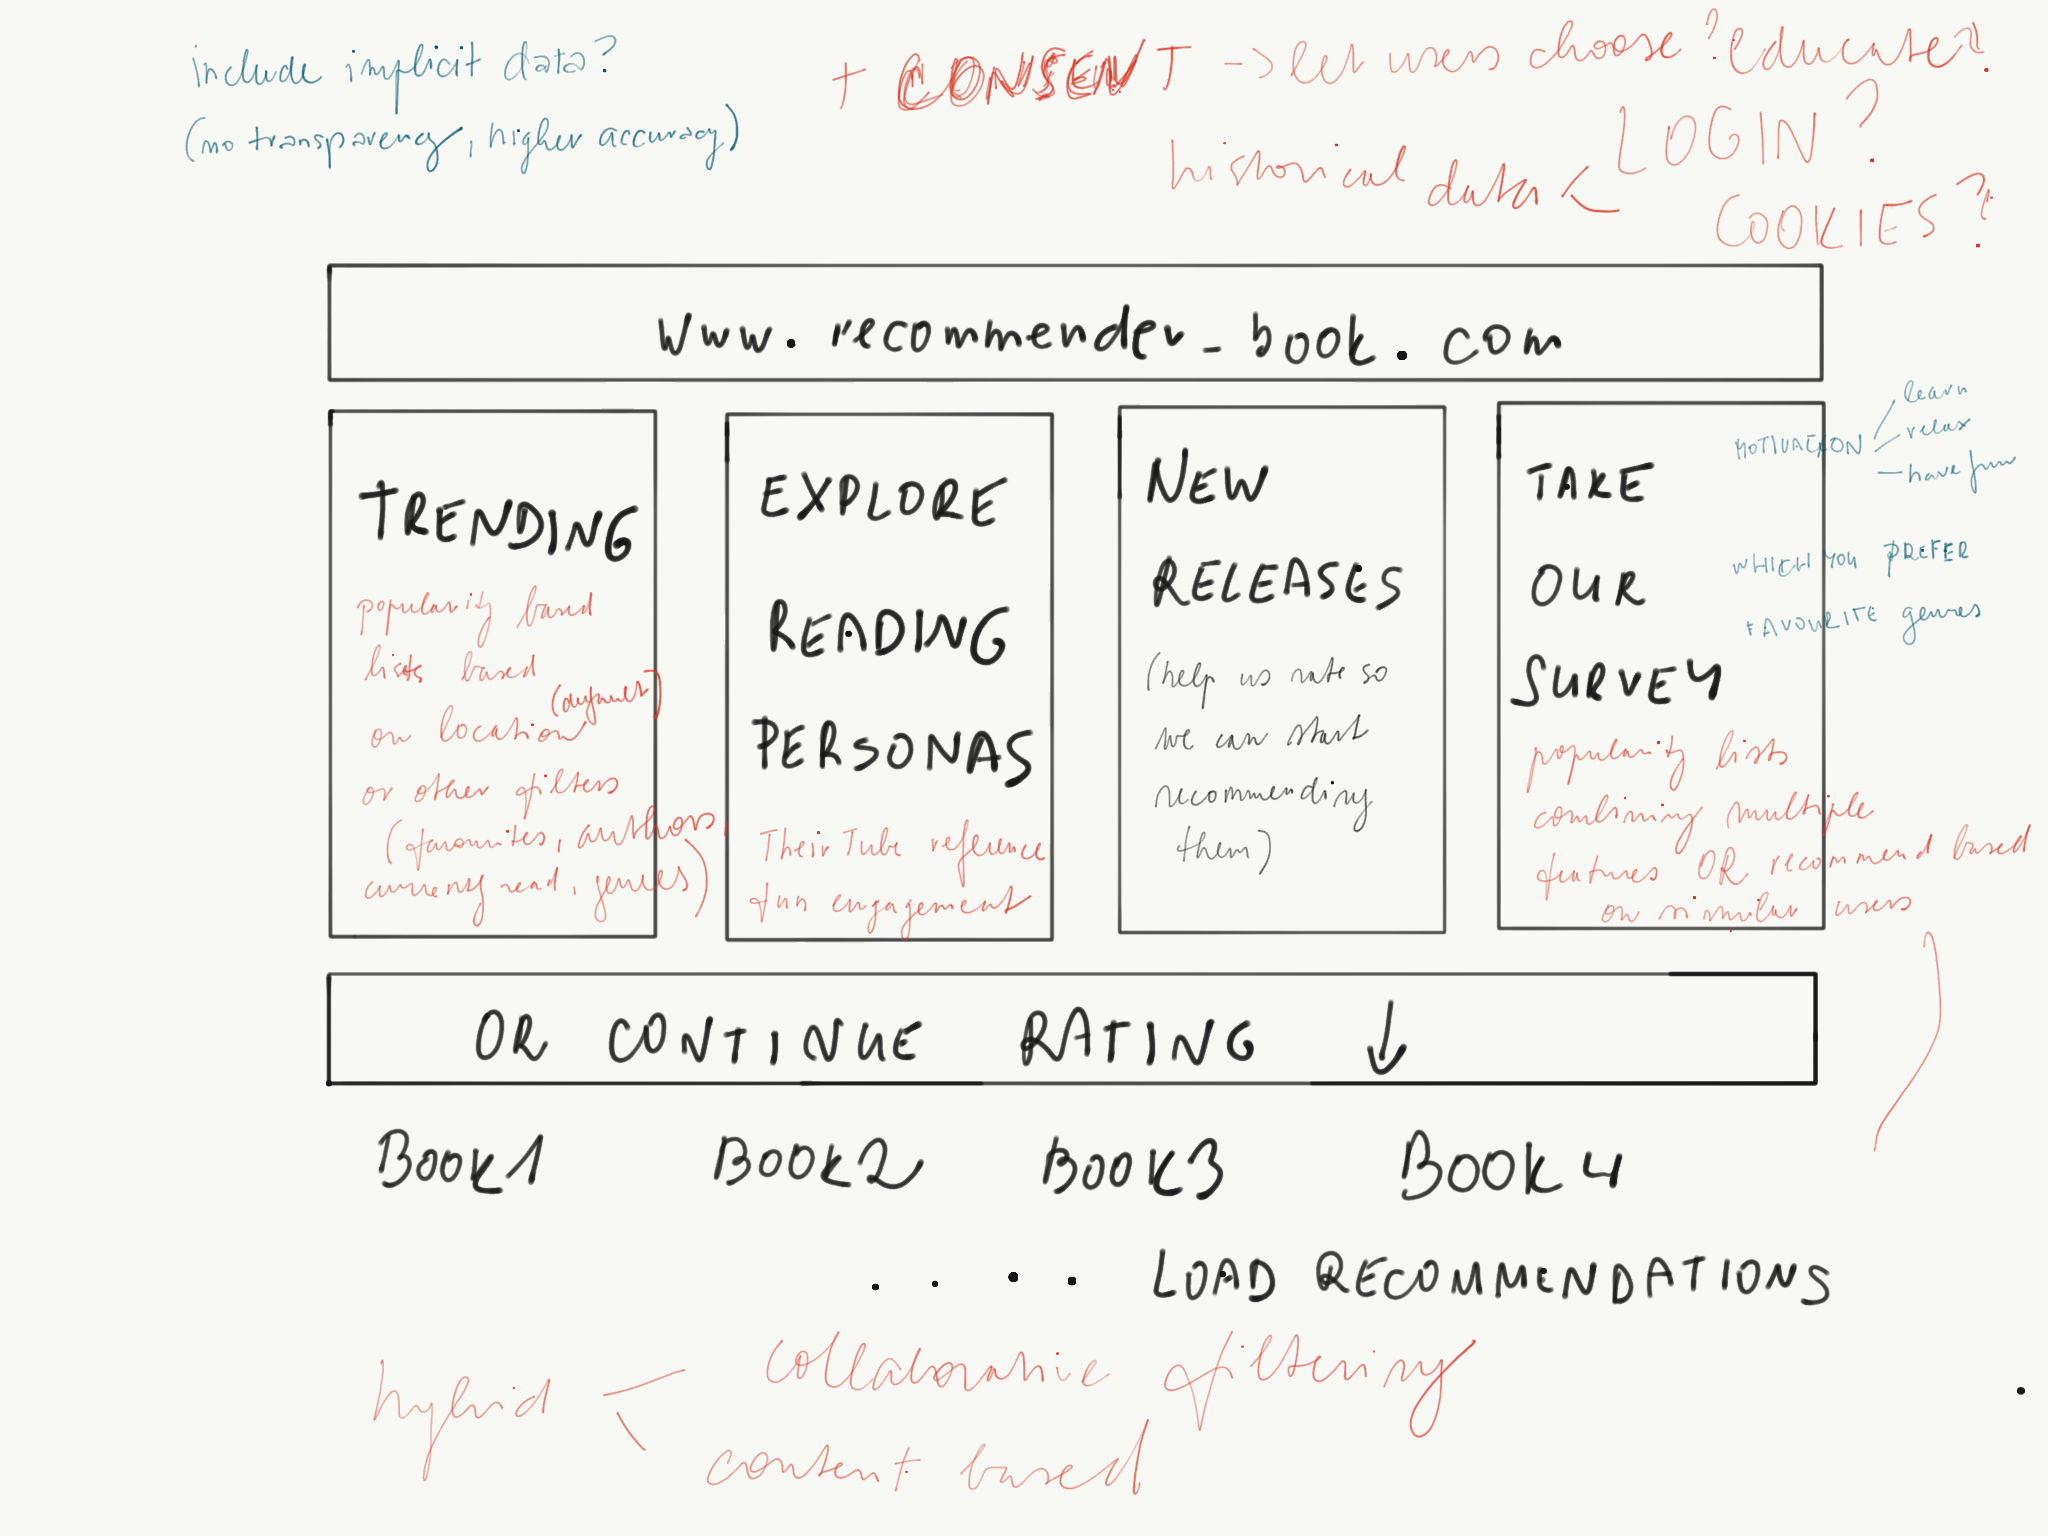